In [3]:
import pandas as pd 
df = pd.read_csv("GamePass_Games.csv", header=1)
print(df.head(5))

                          Game     System xCloud  Status     Added Removed  \
0        Bratz: Rhythm & Style  Xbox / PC    Yes  Active  Dec 2025     NaN   
1              Mortal Kombat 1  Xbox / PC    Yes  Active  Dec 2025     NaN   
2  A Game About Digging A Hole       Xbox    Yes  Active  Dec 2025     NaN   
3                   Death Howl         PC    NaN  Active  Dec 2025     NaN   
4                  Dome Keeper       Xbox    Yes  Active  Dec 2025     NaN   

   Months   Release   Age Metacritic  Completion             Genre Series X|S  \
0    0.27  Sep 2025  0.25        NaN         NaN  Action-Adventure        NaN   
1    0.30  Sep 2023  2.23         83         NaN  Action-Adventure  Exclusive   
2    0.33  Feb 2025  0.84        NaN         2.0         Adventure  Exclusive   
3    0.33  Dec 2025  0.00        NaN         NaN         Adventure        NaN   
4    0.33  Sep 2022  3.20         90         5.0            Action        NaN   

          Owner Notes ESRB ESRB Content Desc

In [5]:
df = df[df["Status"].isin(["Active", "Leaving Soon"])]
df.size


14360

In [ ]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

async def get_game_data_debug(game_name):
    async with async_playwright() as p:
        # 1. Launch Patchright in stealth mode
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            print(f"[{index+1}/10] Investigating: {game_name}")
        # 2. Refined search query for better accuracy
        search_query = clean_game_name(game_name)
        
        # 2. FORCE THE XBOX DOMAIN
        # This tells DuckDuckGo: "Only show me results from the Xbox Store"
        search_url = f"https://duckduckgo.com/?q=site:xbox.com/en-us/games/store+{search_query}"
        
        try:
            print(f"Investigating: {game_name}")
            await page.goto(search_url)
            
            # 3. Wait for the page to settle
            await page.wait_for_timeout(5000) 


            # 5. Use Locator to find the first link that looks like a store result
            # We look for ANY link containing 'xbox.com' to be safe
            result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
            
            store_link = "Not Found"
            product_id = "N/A"

            # Check if the locator actually found something
            if await result_locator.count() > 0:
                store_link = await result_locator.get_attribute("href")
                match = re.search(r"([a-zA-Z0-9]{12})", store_link)
                product_id = match.group(1) if match else "ID Not Found"
            
            await browser.close()
            return store_link, product_id, screenshot_path
            
        except Exception as e:
            print(f"Error: {e}")
            await browser.close()
            return "Error", "N/A", "None"
        
        

# Run a test
# 2. Grab the first 10 rows
df_first_10 = df.head(10)

# 3. Run the scraper
final_results = await scrape_batch(df_first_10)

# 4. Save to a new CSV
results_df = pd.DataFrame(final_results)
results_df.to_csv('xbox_batch_results.csv', index=False)

print("\n--- Batch Complete! ---")
print(results_df)

[1/10] Investigating: Bratz: Rhythm & Style
[2/10] Investigating: Mortal Kombat 1
[3/10] Investigating: A Game About Digging A Hole
[4/10] Investigating: Death Howl
[5/10] Investigating: Dome Keeper
[6/10] Investigating: Routine
[7/10] Investigating: Lost Records: Bloom & Rage
[8/10] Investigating: Marvel Cosmic Invasion
[9/10] Investigating: Banishers: Ghosts of New Eden
[10/10] Investigating: Kill It With Fire! 2

--- Batch Complete! ---
                            Game  \
0          Bratz: Rhythm & Style   
1                Mortal Kombat 1   
2    A Game About Digging A Hole   
3                     Death Howl   
4                    Dome Keeper   
5                        Routine   
6     Lost Records: Bloom & Rage   
7         Marvel Cosmic Invasion   
8  Banishers: Ghosts of New Eden   
9           Kill It With Fire! 2   

                                       MS_Store_Link     ProductID  
0                                          Not Found           N/A  
1                    

In [ ]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import os
import random
from patchright.async_api import async_playwright

nest_asyncio.apply()

async def scrape_batch(df_subset):
    results = []
    
    async with async_playwright() as p:
        # Launch stealth browser
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            print(f"[{index+1}/10] Investigating: {game_name}")
            
            search_url = f"https://duckduckgo.com/?q={game_name}+xbox+store+links"
            
            try:
                await page.goto(search_url)
                # Wait for results to load
                await page.wait_for_timeout(random.randint(7000)) 

                # Grab the first Xbox store link
                result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
                
                store_link = "Not Found"
                product_id = "N/A"

                if await result_locator.count() > 0:
                    store_link = await result_locator.get_attribute("href")
                    # Remove any UTM parameters before regex
                    clean_link = store_link.split('?')[0]
                    match = re.search(r"([a-zA-Z0-9]{12})", clean_link)
                    product_id = match.group(1) if match else "ID Not Found"
                
                results.append({
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                })
                
                # Human-like pause between games
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error for {game_name}: {e}")
                results.append({"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"})

        await browser.close()
    return results





[1/10] Investigating: Bratz: Rhythm & Style
[2/10] Investigating: Mortal Kombat 1
Error for Mortal Kombat 1: Page.wait_for_timeout: Target page, context or browser has been closed
[3/10] Investigating: A Game About Digging A Hole
Error for A Game About Digging A Hole: Page.goto: Target page, context or browser has been closed
[4/10] Investigating: Death Howl
Error for Death Howl: Page.goto: Target page, context or browser has been closed
[5/10] Investigating: Dome Keeper
Error for Dome Keeper: Page.goto: Target page, context or browser has been closed
[6/10] Investigating: Routine
Error for Routine: Page.goto: Target page, context or browser has been closed
[7/10] Investigating: Lost Records: Bloom & Rage
Error for Lost Records: Bloom & Rage: Page.goto: Target page, context or browser has been closed
[8/10] Investigating: Marvel Cosmic Invasion
Error for Marvel Cosmic Invasion: Page.goto: Target page, context or browser has been closed
[9/10] Investigating: Banishers: Ghosts of New Ede

In [8]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# Helper function to clean names (Fixes the Bratz/Special Char issue)
def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    results = []
    
    # 1. Start Patchright Stealth Browser
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        # 2. Loop through your 10 games
        for index, row in df_subset.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # 3. Targeted Search Query
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/10] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                # Wait for the page to render
                await page.wait_for_timeout(random.randint(4000, 6000)) 

                # 4. Grab the first organic store link
                result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
                
                store_link = "Not Found"
                product_id = "N/A"

                if await result_locator.count() > 0:
                    store_link = await result_locator.get_attribute("href")
                    # Snip the 12-char ID from the clean link
                    clean_link = store_link.split('?')[0]
                    match = re.search(r"([a-zA-Z0-9]{12})", clean_link.strip('/'))
                    product_id = match.group(1) if match else "ID Not Found"
                
                results.append({
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                })
                
                # Human-like pause to prevent IP flagging
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                results.append({"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"})

        await browser.close()
    return results

# --- Main Execution ---
# Make sure your file name matches exactly!
df_first_10 = df.head(10)

# Run the scraper
batch_results = await scrape_xbox_batch(df_first_10)

# Save and View
results_df = pd.DataFrame(batch_results)
results_df.to_csv('xbox_batch_results.csv', index=False)
print("\n--- Batch Complete! ---")
print(results_df)

[1/10] Searching: Bratz: Rhythm & Style
[2/10] Searching: Mortal Kombat 1
[3/10] Searching: A Game About Digging A Hole
[4/10] Searching: Death Howl
[5/10] Searching: Dome Keeper
[6/10] Searching: Routine
[7/10] Searching: Lost Records: Bloom & Rage
[8/10] Searching: Marvel Cosmic Invasion
[9/10] Searching: Banishers: Ghosts of New Eden
[10/10] Searching: Kill It With Fire! 2

--- Batch Complete! ---
                            Game  \
0          Bratz: Rhythm & Style   
1                Mortal Kombat 1   
2    A Game About Digging A Hole   
3                     Death Howl   
4                    Dome Keeper   
5                        Routine   
6     Lost Records: Bloom & Rage   
7         Marvel Cosmic Invasion   
8  Banishers: Ghosts of New Eden   
9           Kill It With Fire! 2   

                                       MS_Store_Link     ProductID  
0  https://www.xbox.com/en-us/games/store/bratz-r...  9p76mmjg50ds  
1                                          Not Found         

In [10]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

def clean_game_name(name):
    """Refines the game title for better search engine matching."""
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    results_file = 'xbox_batch_results.csv'
    results = []
    
    async with async_playwright() as p:
        # Patchright stealth browser initialization
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # Using the 'site:' operator to force official store results
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/{len(df_subset)}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                # Random wait to mimic human browsing behavior
                await page.wait_for_timeout(random.randint(5000, 7000)) 

                # Extracting all links to find the best match
                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                
                store_link = "Not Found"
                product_id = "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        # Clean tracking parameters before ID extraction
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-Z0-9]{12})$", clean_link)
                        
                        if match:
                            store_link = link
                            product_id = match.group(1)
                            break 

                current_result = {
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                }
                results.append(current_result)
                
                # Save-as-you-go: Append this row to the CSV immediately
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file)
                )
                
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                results.append(error_row)
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()
    return results

# --- Main Execution ---
# Ensure your CSV is in the same directory or provide the full path
df_first_10 = df.head(10)
await scrape_xbox_batch(df_first_10)
print("\n--- Batch Complete! Results saved to xbox_batch_results.csv ---")

[1/10] Searching: Bratz: Rhythm & Style
[2/10] Searching: Mortal Kombat 1
[3/10] Searching: A Game About Digging A Hole
[4/10] Searching: Death Howl
[5/10] Searching: Dome Keeper
[6/10] Searching: Routine
[7/10] Searching: Lost Records: Bloom & Rage
[8/10] Searching: Marvel Cosmic Invasion
[9/10] Searching: Banishers: Ghosts of New Eden
[10/10] Searching: Kill It With Fire! 2

--- Batch Complete! Results saved to xbox_batch_results.csv ---


In [17]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# 1. NEW: Logic to reset the file before the loop starts
results_file = 'xbox_batch_results.csv'
if os.path.exists(results_file):
    os.remove(results_file) # Deletes the old file so you start fresh

def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    async with async_playwright() as p:
        # Patchright stealth browser
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # 2. IMPROVED SEARCH: Force results from the official store
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/{len(df_subset)}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                await page.wait_for_timeout(random.randint(5000, 7000)) 

                # Grab all links to ensure we find the right one
                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                
                store_link = "Not Found"
                product_id = "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-r0-9]{12})$", clean_link)
                        if match:
                            store_link = link
                            product_id = match.group(1)
                            break 

                current_result = {"Game": game_name, "MS_Store_Link": store_link, "ProductID": product_id}
                
                # Append to file
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file)
                )
                
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()

# --- Main Execution ---
# 2. Automatically find where you left off
start_index = 0
if os.path.exists(results_file):
    # Count rows in your existing results to find the starting point
    existing_df = pd.read_csv(results_file)
    start_index = len(existing_df)
    print(f"Resuming from row {start_index}...")

# 3. Create a subset of ONLY the remaining games
df_remaining = df.iloc[start_index:]

# 4. Run the scraper on ONLY the remaining rows
await scrape_xbox_batch(df_remaining)

print(f"\nBatch Complete! All results are in {results_file}")


[1/2158] Searching: Bratz: Rhythm & Style
Error on Bratz: Rhythm & Style: Page.wait_for_timeout: Target page, context or browser has been closed
[2/2158] Searching: Mortal Kombat 1
Error on Mortal Kombat 1: Page.goto: Target page, context or browser has been closed
[3/2158] Searching: A Game About Digging A Hole
Error on A Game About Digging A Hole: Page.goto: Target page, context or browser has been closed
[4/2158] Searching: Death Howl
Error on Death Howl: Page.goto: Target page, context or browser has been closed
[5/2158] Searching: Dome Keeper
Error on Dome Keeper: Page.goto: Target page, context or browser has been closed
[6/2158] Searching: Routine
Error on Routine: Page.goto: Target page, context or browser has been closed
[7/2158] Searching: Lost Records: Bloom & Rage
Error on Lost Records: Bloom & Rage: Page.goto: Target page, context or browser has been closed
[8/2158] Searching: Marvel Cosmic Invasion
Error on Marvel Cosmic Invasion: Page.goto: Target page, context or browse

In [24]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# 1. SETUP: Point to your results file
results_file = 'xbox_batch_results.csv'

def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_to_scrape):
    async with async_playwright() as p:
        # headless=True keeps this running quietly in the background
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_to_scrape.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            
            # This uses the index from your original master df
            print(f"[{index+1}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                await page.wait_for_timeout(random.randint(4000, 6000)) 

                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                store_link, product_id = "Not Found", "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-Z0-9]{12})$", clean_link)
                        if match:
                            store_link, product_id = link, match.group(1)
                            break 

                current_result = {"Game": game_name, "MS_Store_Link": store_link, "ProductID": product_id}
                
                # APPEND: Add to the bottom of the existing file
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file) # Header only if file is brand new
                )
                
                await asyncio.sleep(random.uniform(1, 2))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                # Save the error state so you don't keep retrying it on resume
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()

# --- Main Execution (Using your pre-loaded 'df') ---

# 2. Resuming logic: Find out how many rows we already finished
start_index = 0
if os.path.exists(results_file):
    existing_results = pd.read_csv(results_file)
    start_index = len(existing_results)
    print(f"Resuming from index {start_index}...")

# 3. SLICE the existing 'df' to get only what is left
df_remaining = df.iloc[start_index:]

# 4. RUN only if there is work left
if not df_remaining.empty:
    await scrape_xbox_batch(df_remaining)
else:
    print("Dataset already fully scraped.")

print(f"\nDone! Results saved to {results_file}")

Resuming from index 238...
[239] Searching: Zork I: The Great Underground 
[240] Searching: Zork Zero: The Revenge of Megaboz
[241] Searching: Monster Train 2
[242] Searching: DOOM: The Dark Ages
[243] Searching: Firefighting Simulator: The Squad
[244] Searching: Police Simulator: Patrol Officers
[245] Searching: Kulebra and the Souls of Limbo
[246] Searching: Warhammer: Vermintide 2
[247] Searching: Revenge of the Savage Planet
[248] Searching: Dragon Ball Xenoverse 2
[249] Searching: DREDGE
[250] Searching: Anno 1800
[251] Searching: Call of Duty: Modern Warfare II
[252] Searching: Far Cry 4
[253] Searching: Towerborne (Game Preview)
[254] Searching: Clair Obscur: Expedition 33
[255] Searching: The Elder Scrolls IV: Oblivion - Remastered
[256] Searching: Crime Scene Cleaner
[257] Searching: Tempopo
[258] Searching: SpongeBob SquarePants: The Patrick Star Game
[259] Searching: Grand Theft Auto V
[260] Searching: Blue Prince
[261] Searching: NHL 25
[262] Searching: Commandos: Origins
[

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished ex

[301] Searching: Microsoft Flight Simulator 2024
[302] Searching: Spyro Reignited Trilogy
[303] Searching: Goat Simulator: Remastered
[304] Searching: Starcraft: Remastered
[305] Searching: Starcraft II: Campaign Collection
[306] Searching: Call of Duty: Black Ops 6
[307] Searching: Ashen
[308] Searching: Call of Duty: Warzone
[309] Searching: Donut County
[310] Searching: Mechwarrior 5: Clans
[311] Searching: South Park: The Fractured but Whole
[312] Searching: Inscryption
[313] Searching: Mad Streets
[314] Searching: SIFU
[315] Searching: Legend of Mana (2021)
[316] Searching: Trials of Mana (2020)
[317] Searching: Ara: History Untold
[318] Searching: Frostpunk 2
[319] Searching: Overwatch 2
[320] Searching: Train Sim World 5
[321] Searching: Riders Republic
[322] Searching: Expeditions: A MudRunner Game
[323] Searching: Age of Mythology: Retold
[324] Searching: Star Trucker
[325] Searching: DOOM + DOOM II: Enhanced
[326] Searching: Atlas Fallen: Reign of Sand
[327] Searching: Crash 

In [6]:
DF = pd.read_csv("xbox_batch_results.csv")
DF.merge(df, on="Game", how="right").to_csv('xbox_merged_results.csv', index=False)

In [8]:
df_clean = pd.read_csv('xbox_merged_results.csv')
df_clean = df_clean[df_clean['MS_Store_Link'] != 'Not Found']
df_clean.to_csv('xbox_final_cleaned_results.csv', index=False)

In [8]:
from prepare_data import prepare_games_dataset
from prepare_data import create_tidy_json
print("=" * 80)
print("PREPARING XBOX DATA FOR ANALYSIS")
print("=" * 80)
    
df = prepare_games_dataset("xbox_data_20251224_1937.json")
    
    
 # Step 2: Save as tidy JSON
create_tidy_json(df, "xbox_tidy.json")
    
# Step 3: Also save as CSV for quick review
df.to_csv("xbox_prepared.csv", index=False)
print("✓ Saved to xbox_prepared.csv")



PREPARING XBOX DATA FOR ANALYSIS
📊 Prepared 1389 games with engagement data
   (Excluded 44 games with zero ratings)
✓ Saved 1389 games to xbox_tidy.json
✓ Saved to xbox_prepared.csv


In [11]:
DF_clean = pd.read_csv('xbox_final_cleaned_results.csv')
Final = df.merge(DF_clean, right_on="ProductID", left_on="product_id", how="left")
Final.to_csv('xbox_final_merged_data.csv', index=False)
print("✓ Final merged data saved to xbox_final_merged_data.csv")

✓ Final merged data saved to xbox_final_merged_data.csv


In [ ]:


rating_7d = pd.to_numeric(Final["rating_7_days_avg"], errors='coerce').fillna(0)
rating_30d = pd.to_numeric(Final["rating_30_days_avg"], errors='coerce').fillna(0)
rating_all = pd.to_numeric(Final["rating_alltime_avg"], errors='coerce').fillna(0)



In [14]:

genre_performance = pd.read_csv('Genre_performance.csv')

In [13]:
genre_performance = genre_performance[genre_performance['Genre'] != 'Unknown']
genre_performance = genre_performance[genre_performance['game_count'] > 5]

NameError: name 'genre_performance' is not defined

/var/folders/bh/dh1w_fld0j96ldg4hvhzhdw00000gn/T/ipykernel_31158/1035239243.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


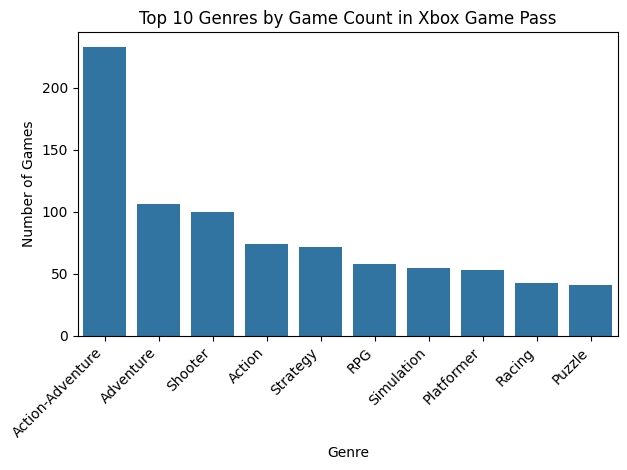

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
genre_performance_10 = genre_performance.sort_values(by='game_count', ascending=False).head(10)
ax = sns.barplot(data=genre_performance_10, x='Genre', y = 'game_count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 10 Genres by Game Count in Data Set ')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.tight_layout()

/var/folders/bh/dh1w_fld0j96ldg4hvhzhdw00000gn/T/ipykernel_51926/352492152.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


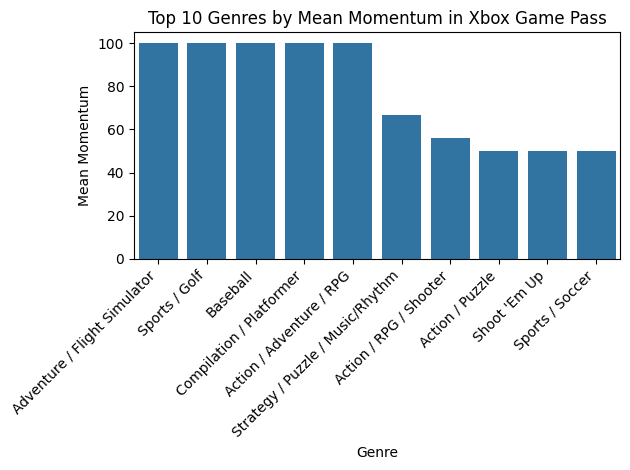

In [ ]:
genre_performance_10 = genre_performance.sort_values(by='momentum_mean', ascending=False).head(10)
ax = sns.barplot(x='Genre', y='momentum_mean', data=genre_performance_10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 10 Genres by Mean Momentum in Xbox (Both formerly on GamePass and those in the store)')
plt.xlabel('Genre')
plt.ylabel('Mean Momentum')
plt.tight_layout()
#Something that I think I am realizing now is that this analysis is maybe a little bit flawed because it only includes games from game pass and those that have left gamepass as those not in gp which u know maybe a confounding variable is that they left GP bc they did not perform well 

In [2]:
import pandas as pd

genre_gamepass = pd.read_csv('Genre_gamepass_comparison_fixed.csv')
genre_gamepass.columns


Index(['Genre', 'has_gamepass_remediation', 'momentum_mean',
       'discovery_capture_mean', 'quality_retention_mean',
       'rating_7_days_avg_mean', 'rating_7_days_avg_std',
       'rating_7_days_avg_median', 'rating_30_days_avg_mean',
       'rating_30_days_avg_std', 'rating_30_days_avg_median',
       'rating_alltime_avg_mean', 'rating_alltime_avg_std',
       'rating_alltime_avg_median', 'rating_7_days_count_mean',
       'rating_7_days_count_std', 'rating_7_days_count_median',
       'rating_30_days_count_mean', 'rating_30_days_count_std',
       'rating_30_days_count_median', 'rating_alltime_count_mean',
       'rating_alltime_count_std', 'rating_alltime_count_median',
       'has_gamepass_remediation_sum', 'game_count_count'],
      dtype='object')

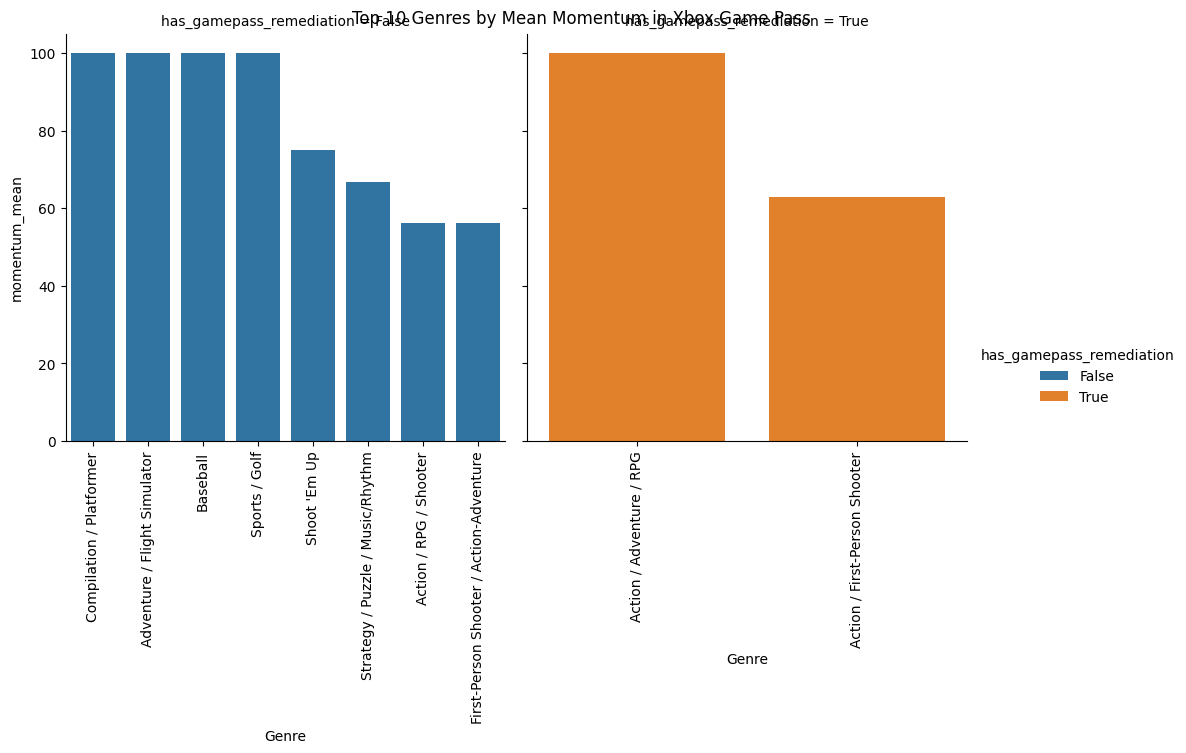

In [16]:
import seaborn as sns 
import matplotlib.pyplot as plt
genre_performance_10_gp = genre_gamepass.sort_values(by='momentum_mean', ascending=False).head(10)
g = sns.catplot(data = genre_performance_10_gp, x='Genre', y='momentum_mean', hue='has_gamepass_remediation', kind = 'bar', col = 'has_gamepass_remediation', sharex=False)
g.set_xticklabels(rotation = 90)
g.fig.suptitle('Top 10 Genres by Mean Momentum in Xbox Game Pass')
g.fig.subplots_adjust(wspace=0.05)

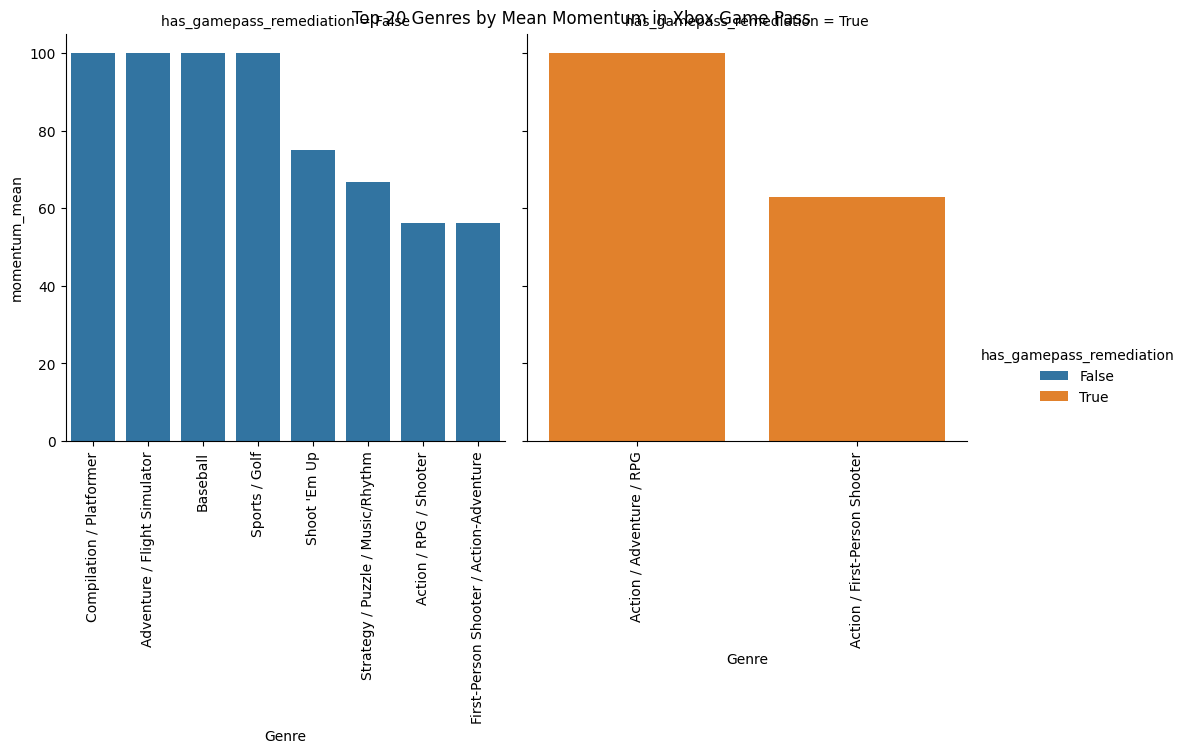

In [ ]:

genre_gamepass_10 = genre_gamepass.sort_values(by='momentum_mean', ascending=False).head(10)
g = sns.catplot(data = genre_gamepass_10, x='Genre', y='momentum_mean', hue='has_gamepass_remediation', kind = 'bar', col = 'has_gamepass_remediation', sharex=False)
g.set_xticklabels(rotation = 90)
g.fig.suptitle('Top 20 Genres by Mean Momentum in Xbox Game Pass')
g.fig.subplots_adjust(wspace=0.05)

In [ ]:
#Ok so I have this code where I know what genres have the typically the highest mean momentum
#What I want to see is if I can get one chart to show me among game pass games these genres performed this and then have the exact same graph against that for games not in game pass to compare them 
#The Major problem that I am running into right now is that in that other data set I used a genre analysis DF where I did not include the game pass remediation 
#So what I could do is create a for loop (probably) for the games in the game and then just save them in a data structure and then just filter that into the list 

#create a for loop to save it in a PD series?
genre_performance_10 = genre_gamepass.sort_values(by='momentum_mean', ascending=False).head(10)
top_genres = genre_performance_10['Genre'].tolist()
filter = genre_gamepass[genre_gamepass['Genre'].isin(top_genres)]   

#Filter 2 different data sets one where the game pass remediation is true and 

genre_results_with_gp = filter[filter ['has_gamepass_remediation'] == True]
genre_results_without_gp = filter[filter ['has_gamepass_remediation'] == False]


#The other one where it is not to use in the visualization 

In [25]:
filter.head()

,Genre,has_gamepass_remediation,momentum_mean,discovery_capture_mean,quality_retention_mean,rating_7_days_avg_mean,rating_7_days_avg_std,rating_7_days_avg_median,rating_30_days_avg_mean,rating_30_days_avg_std,...,rating_7_days_count_std,rating_7_days_count_median,rating_30_days_count_mean,rating_30_days_count_std,rating_30_days_count_median,rating_alltime_count_mean,rating_alltime_count_std,rating_alltime_count_median,has_gamepass_remediation_sum,game_count_count
6,Action / Adventure / RPG,True,100.00,0.38,-2.10,1.00,NaN,1.00,1.00,NaN,...,NaN,1.0,1.0,NaN,1.0,261.00,NaN,261.0,1.0,1.0
18,Action / First-Person Shooter,False,32.06,0.78,-0.18,3.92,1.73,4.60,3.76,1.57,...,2.42,1.0,7.5,4.17,7.0,1014.88,843.74,721.0,0.0,8.0
19,Action / First-Person Shooter,True,63.04,0.19,0.40,3.85,0.21,3.85,4.00,0.00,...,3.54,3.5,12.0,15.56,12.0,1853.00,1868.18,1853.0,2.0,2.0
35,Action / RPG / Shooter,False,56.25,0.14,0.80,4.95,0.07,4.95,4.65,0.35,...,3.54,4.5,8.0,0.00,8.0,5356.00,3457.75,5356.0,0.0,2.0
67,Adventure / Flight Simulator,False,100.00,0.51,1.80,5.00,NaN,5.00,5.00,NaN,...,NaN,1.0,1.0,NaN,1.0,198.00,NaN,198.0,0.0,1.0


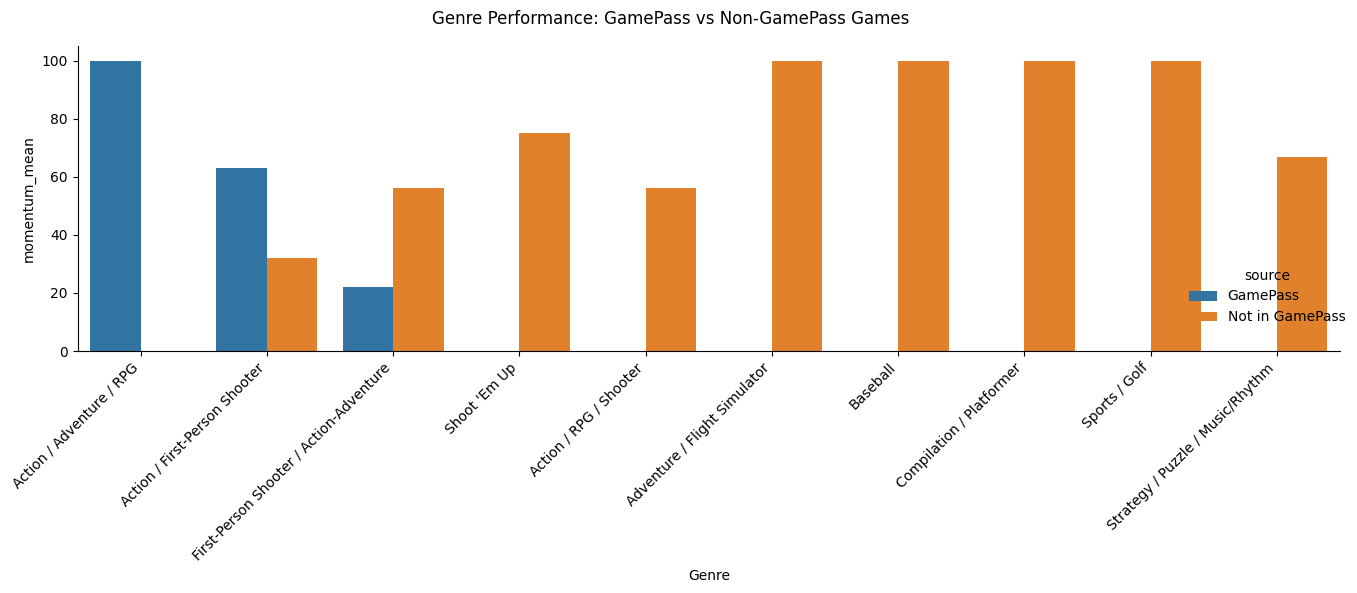

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine both DataFrames with a source column for hue
comparsion_df_with = pd.concat([
    genre_results_with_gp.assign(source='GamePass'),
    genre_results_without_gp.assign(source='Not in GamePass')
])

# Create side-by-side comparison
g = sns.catplot(
    data=comparsion_df_with,
    x='Genre',
    y='momentum_mean',
    hue='source',
    kind='bar',
    height=6,
    aspect=2
)
g.set_xticklabels(rotation=45, ha='right')
g.fig.suptitle('Genre Performance: GamePass vs Non-GamePass Games')
plt.tight_layout()

In [24]:
# inspect values and types
print(filter['has_gamepass_remediation'].dtype)
print(filter['has_gamepass_remediation'].unique())
print("NaN genres:", filter[filter['has_gamepass_remediation'].isna()]['Genre'].unique())

# see counts per genre x remediation
print(filter.groupby(['Genre','has_gamepass_remediation']).size().unstack(fill_value=0))

# check for whitespace/case issues in Genre
print(sorted(filter['Genre'].unique()) == sorted([g.strip() for g in filter['Genre'].unique()]))

bool
[ True False]
NaN genres: []
has_gamepass_remediation                 False  True 
Genre                                                
Action / Adventure / RPG                     0      1
Action / First-Person Shooter                1      1
Action / RPG / Shooter                       1      0
Adventure / Flight Simulator                 1      0
Baseball                                     1      0
Compilation / Platformer                     1      0
First-Person Shooter / Action-Adventure      1      1
Shoot 'Em Up                                 1      1
Sports / Golf                                1      0
Strategy / Puzzle / Music/Rhythm             1      0
True


In [16]:
#What I am going to do now is to create a new DF that will have the differnece ebtween the momentum mean of the games in game pass vs those not in game pass for each genre
genre_comparison = genre_gamepass.pivot_table(index='Genre', columns='has_gamepass_remediation', values='momentum_mean').reset_index()
genre_comparison['momentum_difference'] = genre_comparison[True] - genre_comparison[False]
genre_comparison.sort_values(by = "momentum_difference", ascending=False).head(10)

NameError: name 'genre_gamepass' is not defined

In [3]:
import numpy as np
import pandas as pd

genre_gp = pd.read_csv("Genre_gamepass_comparison.csv")   
genre_all = pd.read_csv("Genre_performance.csv")               

# rename base column and merge
genre_all_baseline = genre_all[['Genre','momentum_mean', 'discovery_capture_median', 'quality_retention_median']].rename(columns={'momentum_mean':'momentum_genre_baseline', 'discovery_capture_median': 'discovery_capture_baseline', 'quality_retention_median' : 'quality_retention_baseline'})
merged = genre_gp.merge(genre_all_baseline, on='Genre', how='left')

# differences (row-level: GP True/False rows will get baseline)
merged['momentum_diff_vs_baseline'] = merged['momentum_mean'] - merged['momentum_genre_baseline']
merged['momentum_pct_vs_baseline'] = merged['momentum_diff_vs_baseline'] / merged['momentum_genre_baseline'].replace(0,np.nan) * 100
merged['discovery_capture_diff_vs_baseline'] = merged['discovery_capture_median'] - merged['discovery_capture_baseline']
merged['quality_retention_vs_baseline'] = merged['quality_retention_median'] - merged['quality_retention_baseline']
merged['quality_pct_vs_baseline'] = merged['quality_retention_vs_baseline'] / merged['quality_retention_baseline'].replace(0,np.nan) * 100



merged.head(10)


,Genre,has_gamepass_remediation,momentum_mean,momentum_std,momentum_median,discovery_capture_mean,discovery_capture_std,discovery_capture_median,quality_retention_mean,quality_retention_std,...,rating_alltime_count_median,game_count,momentum_genre_baseline,discovery_capture_baseline,quality_retention_baseline,momentum_diff_vs_baseline,momentum_pct_vs_baseline,discovery_capture_diff_vs_baseline,quality_retention_vs_baseline,quality_pct_vs_baseline
0,Action,False,32.74,38.23,16.67,0.28,1.27,0.02,-0.51,1.82,...,894.0,63,32.36,0.03,0.1,0.38,1.174289,-0.01,0.00,0.0
1,Action,True,30.18,21.97,30.56,0.34,0.47,0.15,0.31,0.47,...,5796.0,11,32.36,0.03,0.1,-2.18,-6.736712,0.12,0.10,100.0
2,Action / Action-Adventure,False,30.47,31.91,27.78,0.15,0.18,0.09,0.60,0.72,...,2022.0,3,31.04,0.08,0.2,-0.57,-1.836340,0.01,0.20,100.0
3,Action / Action-Adventure,True,32.76,NaN,32.76,0.08,NaN,0.08,-0.20,NaN,...,23978.0,1,31.04,0.08,0.2,1.72,5.541237,0.00,-0.40,-200.0
4,Action / Adventure,False,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.73,...,2191.0,3,0.00,0.00,-2.0,0.00,NaN,0.00,0.00,-0.0
5,Action / Adventure / Platformer,False,25.00,NaN,25.00,0.14,NaN,0.14,2.40,NaN,...,703.0,1,25.00,0.14,2.4,0.00,0.000000,0.00,0.00,0.0
6,Action / Adventure / RPG,True,100.00,NaN,100.00,0.38,NaN,0.38,-2.10,NaN,...,261.0,1,100.00,0.38,-2.1,0.00,0.000000,0.00,0.00,-0.0
7,Action / Adventure / RPG / Simulation,False,0.00,NaN,0.00,0.00,NaN,0.00,1.50,NaN,...,829.0,1,0.00,0.00,1.5,0.00,NaN,0.00,0.00,0.0
8,Action / Adventure / Shooter,False,0.00,NaN,0.00,0.00,NaN,0.00,0.90,NaN,...,3387.0,1,0.00,0.00,0.9,0.00,NaN,0.00,0.00,0.0
9,Action / Brawler,False,11.76,16.64,11.76,0.02,0.04,0.02,0.15,0.92,...,3819.0,2,17.91,0.05,0.4,-6.15,-34.338358,-0.03,-0.25,-62.5


In [24]:
#Now I want the differnece between each other as something to work with
pivot = merged.pivot_table(index = 'Genre', values = ['momentum_mean','discovery_capture_median', 'quality_retention_median'], columns= 'has_gamepass_remediation',fill_value = 0).reset_index()
#Flatten the columns so its easier to work with ltr
pivot.columns = [
f'{col[0]}_{col[1]}' if col[1] != '' else col[0]
    for col in pivot.columns
]

pivot['momentum_lift'] = pivot['momentum_mean_True'] - pivot['momentum_mean_False']
pivot['discovery_lift'] = pivot['discovery_capture_median_True'] - pivot['discovery_capture_median_False']
pivot['quality_lift'] = pivot['quality_retention_median_True'] - pivot['quality_retention_median_False']

print(pivot[['Genre', 'momentum_lift', 'discovery_lift', 'quality_lift']].head())

lift_results = pivot[['Genre', 'momentum_lift', 'discovery_lift', 'quality_lift']]

# 3. Merge them back into the original 'merged' dataframe
merged = merged.merge(lift_results, on='Genre', how='left')

# 4. Check the results



merged.to_csv("xbox_final_data.csv")

                             Genre  momentum_lift  discovery_lift  \
0                           Action          -2.56            0.13   
1        Action / Action-Adventure           2.29           -0.01   
2               Action / Adventure           0.00            0.00   
3  Action / Adventure / Platformer         -25.00           -0.14   
4         Action / Adventure / RPG         100.00            0.38   

   quality_lift  
0           0.1  
1          -0.6  
2           2.0  
3          -2.4  
4          -2.1  


In [5]:
merged.head()

,Genre,has_gamepass_remediation,momentum_mean,momentum_std,momentum_median,discovery_capture_mean,discovery_capture_std,discovery_capture_median,quality_retention_mean,quality_retention_std,...,discovery_capture_baseline,quality_retention_baseline,momentum_diff_vs_baseline,momentum_pct_vs_baseline,discovery_capture_diff_vs_baseline,quality_retention_vs_baseline,quality_pct_vs_baseline,momentum_lift,discovery_lift,quality_lift
0,Action,False,32.74,38.23,16.67,0.28,1.27,0.02,-0.51,1.82,...,0.03,0.1,0.38,1.174289,-0.01,0.0,0.0,-2.56,0.13,0.1
1,Action,True,30.18,21.97,30.56,0.34,0.47,0.15,0.31,0.47,...,0.03,0.1,-2.18,-6.736712,0.12,0.1,100.0,-2.56,0.13,0.1
2,Action / Action-Adventure,False,30.47,31.91,27.78,0.15,0.18,0.09,0.60,0.72,...,0.08,0.2,-0.57,-1.836340,0.01,0.2,100.0,2.29,-0.01,-0.6
3,Action / Action-Adventure,True,32.76,NaN,32.76,0.08,NaN,0.08,-0.20,NaN,...,0.08,0.2,1.72,5.541237,0.00,-0.4,-200.0,2.29,-0.01,-0.6
4,Action / Adventure,False,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.73,...,0.00,-2.0,0.00,NaN,0.00,0.0,-0.0,0.00,0.00,2.0


In [ ]:
#What if I wanted to see what percentage of the lift catagories are positive 
#I would need to do the length of the columns that are positive - length of those that are not positive 

momentum_condition = (merged['momentum_diff_vs_baseline'] >= 0)
quality_condition = (merged['quality_retention_vs_baseline'] >= 0)
discovery_condition = (merged['discovery_capture_diff_vs_baseline'] >= 0)
gamepass_condition = (merged['has_gamepass_remediation'] == True)

percentage_momentum = len(merged[momentum_condition & gamepass_condition]) / (len(merged['momentum_diff_vs_baseline'])/)2
percentage_quality = len(merged[quality_condition & gamepass_condition]) / len(merged['quality_retention_vs_baseline'])/2
percentage_discovery = len(merged[discovery_condition & gamepass_condition]) / len(merged['discovery_capture_diff_vs_baseline'])/2

print(percentage_momentum,percentage_quality,percentage_discovery)


0.10743801652892562 0.128099173553719 0.1322314049586777


In [ ]:
#What if I wanted to see what percentage of the baseline catagories are positive 
#I would need to do the length of the columns that are positive - length of those that are not positive 

percentage_momentum = len(merged[merged['momentum_lift'] >= 0 ])/len(merged['momentum_lift'])
percentage_quality = len(merged[merged['quality_lift'] >= 0 ])/len(merged['quality_lift'])
percentage_discovery = len(merged[merged['discovery_lift'] >= 0 ])/len(merged['discovery_lift'])
print(percentage_momentum, percentage_quality, percentage_discovery)

/var/folders/bh/dh1w_fld0j96ldg4hvhzhdw00000gn/T/ipykernel_1690/1461627022.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


[Text(0, 0, 'Adventure / Puzzle'),
 Text(1, 0, 'Sports / Fishing'),
 Text(2, 0, 'Action / First-Person Shooter'),
 Text(3, 0, 'Puzzle / Platformer / Action-Adventure'),
 Text(4, 0, 'Dual-Joystick Shooter'),
 Text(5, 0, "Beat-'Em-Up "),
 Text(6, 0, 'Strategy / Card Game'),
 Text(7, 0, 'Puzzle'),
 Text(8, 0, 'Action / RPG / Action-Adventure'),
 Text(9, 0, 'Action / Simulation')]

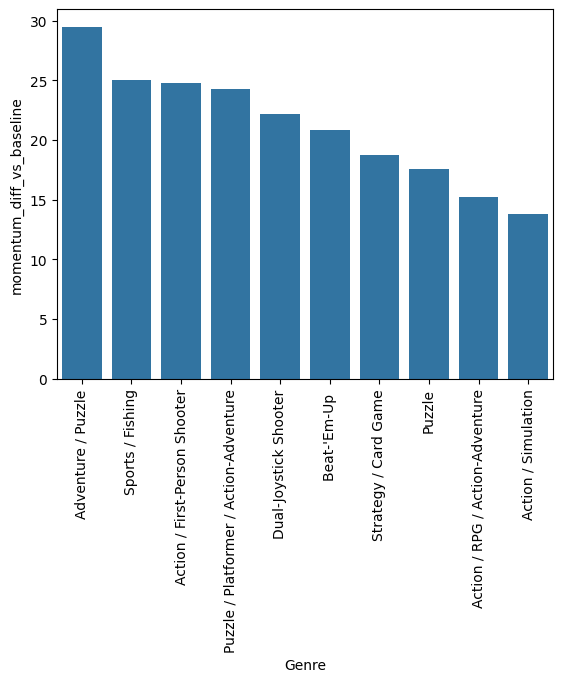

In [15]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Make a viz of game pass games that performed really well comapred to the basleine 

#Filter the data frame and then sort the data frame 
merged_gp = merged[merged['has_gamepass_remediation'] == True].sort_values(by = 'momentum_diff_vs_baseline', ascending= False).head(10)
ax = sns.barplot(data = merged_gp, x = 'Genre', y = 'momentum_diff_vs_baseline')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

Text(0.5, 1.0, 'Game Pass Impact: Discovery vs. Retention by Genre')

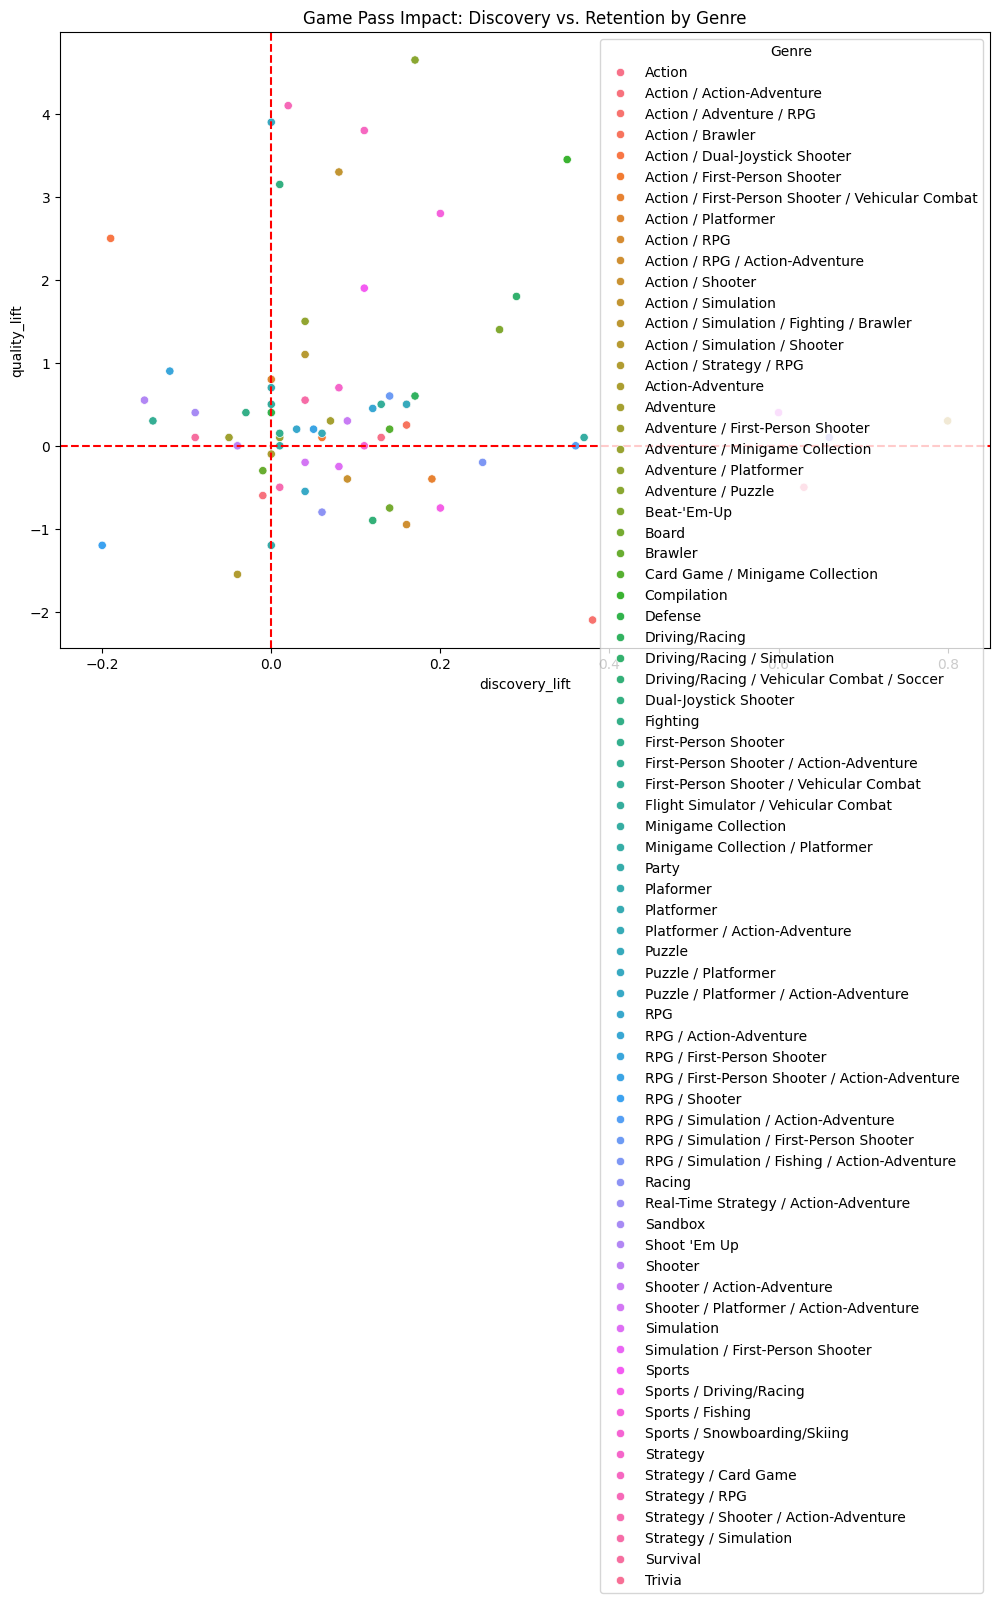

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to only show one row per genre (since Lift is the same for True/False)
lift_df = merged[merged['has_gamepass_remediation'] == True]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=lift_df, x='discovery_lift', y='quality_lift', hue='Genre')
plt.axhline(0, color='red', linestyle='--') # Baseline Quality
plt.axvline(0, color='red', linestyle='--') # Baseline Discovery
plt.title("Game Pass Impact: Discovery vs. Retention by Genre")

In [26]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_stats(df_all, metrics):
    results = []
    
   
    genres = df_all['Genre'].unique()
    
    for genre in genres:
        genre_data = df_all[df_all['Genre'] == genre]
        
        # Split into two groups
        gp_group = genre_data[genre_data['has_gamepass_remediation'] == True]
        paid_group = genre_data[genre_data['has_gamepass_remediation'] == False]
        
        # We need enough samples in both groups to run a test
        if len(gp_group) < 2 or len(paid_group) < 2:
            continue
            
        res = {'Genre': genre}
        
        for metric in metrics:
            
            t_stat, p_val = stats.ttest_ind(gp_group[metric], paid_group[metric], nan_policy='omit')
            
            # 2. Cohen's d (Effect Size)
            n1, n2 = len(gp_group), len(paid_group)
            var1, var2 = gp_group[metric].var(), paid_group[metric].var()
            pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
            
            mean_diff = gp_group[metric].mean() - paid_group[metric].mean()
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
            
            # 3. Confidence Interval (95%)
            se = np.sqrt((var1/n1) + (var2/n2))
            ci_low = mean_diff - (1.96 * se)
            ci_high = mean_diff + (1.96 * se)
            
            # Store results
            res[f'{metric}_p_value'] = round(p_val, 4)
            res[f'{metric}_cohens_d'] = round(cohens_d, 3)
            res[f'{metric}_CI_lower'] = round(ci_low, 2)
            res[f'{metric}_CI_upper'] = round(ci_high, 2)
            res[f'{metric}_significant'] = p_val < 0.05
            
        results.append(res)
        
    return pd.DataFrame(results)

# --- Usage ---
metrics_to_test = ['momentum', 'discovery_capture', 'quality_retention']
stats_df = calculate_stats(merged, metrics_to_test)